# Detection of Master Regulators on a dummy example

This vignette displays some examples of what can be achieved using **NORDic** in order to detect master regulators.

## Installation

In [1]:
import NORDic
! pip freeze | grep "NORDic"

-e git+https://github.com/clreda/nordic.git@859bd0341858399c88ca776d508024c9ed4c66c5#egg=NORDic


## Detection of master regulators

**NORDic PMR** exploits a Boolean network in order to find master regulators. Its approach is based on influence maximization. For more information about the method, please have a look at the following [reference](https://clreda.github.io/assets/reda2022prioritization_accepted.pdf):


> Réda, C., & Delahaye-Duriez, A. (2022). Prioritization of Candidate Genes Through Boolean Networks. In *International Conference on Computational Methods in Systems Biology* (pp. 89-121). Springer, Cham.


The input network does not need to be an output of **NORDic NI**, and the corresponding .BNET file can be independenty generated. We illustrate this by feeding to **NORDic PMR** a dummy example.

In [2]:
from subprocess import call as sbcall
save_folder="MODELS/dummy/"
sbcall("mkdir -p "+save_folder, shell=True)

0

### A. Creating the dummy network example

The dummy example has 11 genes named X0, X1, ..., X10 (with one isolated gene X10), and 20 edges. We expect X0 and X1 to be  master regulators, and X10 to have no influence on the network (because it is isolated). Let us test this using **NORDic PMR**.

In [3]:
import pandas as pd
import numpy as np

## List of input nodes for each edge
source = list(map(lambda x: "X%d" % x,[0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,3,4,5]))
## List of target nodes for each edge
target = list(map(lambda x : "X%d" % x,[2,3,4,5,6,7,8,9,2,3,4,5,6,7,8,9,6,7,8,9]))

## List of all genes
genes = list(sorted(list(set(source+target))))+["X10"]

## Create the network (adjacency matrix)
influences = np.zeros((len(genes), len(genes)))
for s, t in zip(source, target):
    influences[genes.index(s)][genes.index(t)] = 1
influences = pd.DataFrame(influences, index=genes, columns=genes).astype(int)
influences

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
X0,0,0,1,1,1,1,1,1,1,1,0
X1,0,0,1,1,1,1,1,1,1,1,0
X2,0,0,0,0,0,0,1,0,0,0,0
X3,0,0,0,0,0,0,0,1,0,0,0
X4,0,0,0,0,0,0,0,0,1,0,0
X5,0,0,0,0,0,0,0,0,0,1,0
X6,0,0,0,0,0,0,0,0,0,0,0
X7,0,0,0,0,0,0,0,0,0,0,0
X8,0,0,0,0,0,0,0,0,0,0,0
X9,0,0,0,0,0,0,0,0,0,0,0


Let us plot the network using **NORDic** functions, and save the corresponding image in *save_folder*/example.png. Parameter *optional* traces edges with dashed lines when set to True, resp. with solid lines when set to False.

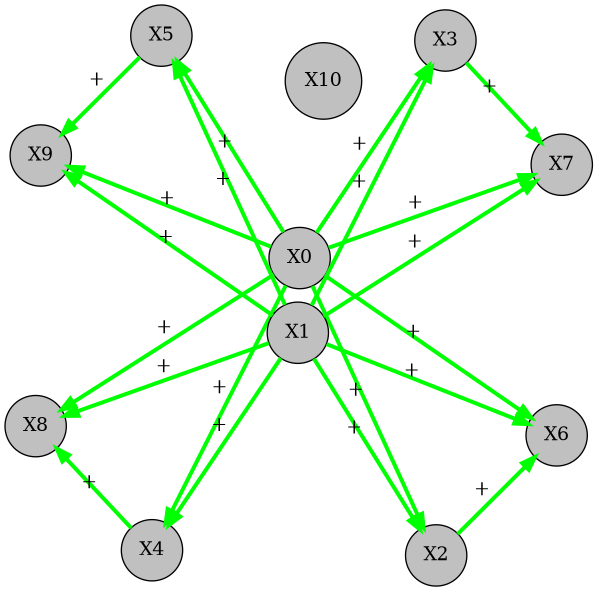

In [4]:
from NORDic.UTILS.utils_plot import influences2graph

influences2graph(influences, save_folder+"example", optional=False, 
                 compile2png=True, engine="sfdp")
from IPython.display import Image
Image(filename=save_folder+'example.png') 

Now that we have built the topology of the network, its dynamics remain to be defined. In that case, we assume that all activators (i.e., regulators connected with an activatory edge) should be active (i.e., an "active" expression level) for the regulated gene to be active.

In [5]:
## Gene regulatory functions (for each node in the network)
grfs = {}
for si, s in enumerate(source):
    t = target[si]
    grf = grfs.get(t, [])
    grfs.update(dict([[t, list(set(grf+[s]))]]))

Now, let us write down the corresponding .BNET file *save_folder*/example.bnet

In [6]:
with open(save_folder+"example.bnet", "w") as f:
    network = []
    for g in genes:
        if (g in grfs):
            network += [g+", "+"&".join(grfs[g])]
        else:
            network += [g+", 1"]
    f.write("\n".join(network))
    
## Print the resulting network
with open(save_folder+"example.bnet", "r") as f:
    network = f.read()
print("\n".join([", ".join(s.split(", ")) for s in network.split("\n")]))

X0, 1
X1, 1
X2, X0&X1
X3, X0&X1
X4, X0&X1
X5, X0&X1
X6, X0&X1&X2
X7, X0&X1&X3
X8, X4&X0&X1
X9, X5&X0&X1
X10, 1


### B. Creating random "patient" samples

In **NORDic PMR**, the ability of a given gene to disrupt the expression of the whole network is tested in a specific disease-related transcriptional context, i.e., patient transcriptional profiles ("states"). Since here the nodes in the network are not related to actual genes, we generate 100 binary states at random. Those states should be a dataframe, with samples/patients in columns, genes in rows.

In [7]:
state_len = 200
states = pd.DataFrame(
  [np.random.choice([0,1], p=[0.5,0.5], size=len(genes)).tolist() for _ in range(state_len)]
  , columns=genes, index=range(state_len)).T
states

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
X0,1,1,0,1,0,0,0,0,1,1,...,1,1,0,0,0,1,0,0,1,1
X1,0,0,1,0,1,0,0,0,0,1,...,0,0,0,1,0,1,1,1,0,0
X2,0,0,1,0,1,1,1,1,1,0,...,0,1,1,0,1,1,1,0,0,0
X3,0,0,1,1,1,1,0,0,0,1,...,0,1,0,0,0,1,0,1,0,1
X4,1,1,1,0,1,1,0,0,0,0,...,1,1,1,0,0,0,0,0,1,0
X5,1,1,0,1,0,0,0,0,1,1,...,1,1,1,0,0,0,1,0,1,1
X6,1,1,1,0,1,1,0,0,1,1,...,0,0,0,0,0,1,0,1,0,1
X7,1,1,0,1,1,1,0,1,0,0,...,1,1,0,0,1,0,1,1,0,0
X8,1,1,0,1,1,0,1,0,1,1,...,0,1,1,0,0,1,0,0,1,1
X9,0,0,1,1,1,1,0,1,0,0,...,1,0,0,0,1,0,1,1,0,1


### C. Selection of parameters

Again, we need to set the random seed for increased reproducibility, and set the maximum number of threads to use:

In [8]:
seed_number=0
from multiprocessing import cpu_count
njobs=min(5,max(1,cpu_count()-2)) #minimum between all available -2 and 5

In order to prove our conjecture (that X0 and X1 are the most regulatory in this network), we set k to 2, that is, we return all the sets of 2 nodes in the network that *roughly* (see paper) maximize the perturbation of the whole network.

In [9]:
k=2

The perturbation of the network should be computed for each gene in the network (list *gene_inputs*), on every "regulatable" gene (that is, a gene which has at least one regulator which is not itself) (list *genes_outputs*).

In [10]:
## Compute the list of "regulatable" genes from the network
with open(save_folder+"example.bnet", "r") as f:
    network = f.read()
gene_outputs = [ x.split(", ")[0] for x in network.split("\n")[:-1] 
    if (x.split(", ")[1] not in [x.split(", ")[0], "0", "1"])]

IM_params = {
    "seed": seed_number, "gene_inputs": genes, # genes to be perturbed
    "gene_outputs": gene_outputs # genes to be observed
}

Let us now set parameters relative to the simulations of trajectories under perturbation of the network (see [mpbn-sim](https://github.com/bnediction/mpbn-sim)):

In [11]:
SIMU_params = {
    'nb_sims': 1000, 'rates': "fully_asynchronous", 'thread_count': njobs,
    'depth': "constant_unitary",
}

All in all

In [12]:
seed_number=12345
from multiprocessing import cpu_count
njobs=min(5,max(1,cpu_count()-2))

k=2

with open(save_folder+"example.bnet", "r") as f:
    network = f.read()
gene_outputs = [ x.split(", ")[0] for x in network.split("\n")[:-1] 
    if (x.split(", ")[1] not in [x.split(", ")[0], "0", "1"])]

IM_params = {
    "seed": seed_number, "gene_inputs": genes,
    "gene_outputs": gene_outputs
}

SIMU_params = {
    'nb_sims': 1000, 'rates': "fully_asynchronous", 'thread_count': njobs,
    'depth': "constant_unitary",
}

### D. Detection of master regulators

Function *greedy* implements the approximately optimal greedy algorithm from the following paper

>Kempe, David, Jon Kleinberg, and Éva Tardos. "Maximizing the spread of influence through a social network." Proceedings of the ninth ACM SIGKDD international conference on Knowledge discovery and data mining. 2003.

It returns the predicted set of master regulators, along with the *spread values* computed at each step of the algorithm for each node. Spread values are correlated with the ability to disrupt the expression of the network (see paper).

In [13]:
from NORDic.NORDic_PMR.functions import greedy

S, spreads = greedy(save_folder+"example.bnet", k, states, IM_params, SIMU_params, 
                    save_folder=save_folder)

<NORD_PMR> Iteration k=1
	<NORD_PMR> Initial state 4 (gene(s):X0)
	<NORD_PMR> Initial state 1 (gene(s):X0)
	<NORD_PMR> Initial state 0 (gene(s):X0)
	<NORD_PMR> Initial state 3 (gene(s):X0)
	<NORD_PMR> Initial state 2 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 4)
Gene X0 (1/11) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 0)
1 wild type attractors with proba > 0 (initial state 1)
Gene X0 (1/11) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 2)
1 wild type attractors with proba > 0 (initial state 3)
Gene X0 (1/11) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2

100%|██████████| 1/1 [00:00<00:00, 50533.78it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 61680.94it/s]

100%|██████████| 1/1 [00:00<00:00, 55188.21it/s]

Gene X9 (10/11) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 5 (gene(s):X0)
	<NORD_PMR> Initial state 6 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 5)
Gene X0 (1/11) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 7 (gene(s):X0)
	<NORD_


100%|██████████| 1/1 [00:00<00:00, 64527.75it/s]

100%|██████████| 1/1 [00:00<00:00, 61680.94it/s]

100%|██████████| 1/1 [00:00<00:00, 59074.70it/s]

Gene X4 (5/11) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 7 - constant_un


100%|██████████| 1/1 [00:00<00:00, 55924.05it/s]

100%|██████████| 1000/1000 [00:00<00:00, 62204.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Gene X0 (1/11) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 14)
Gene X0 (1/11) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 13 - constant_unitary_depth{

100%|██████████| 1000/1000 [00:00<00:00, 70277.54it/s]


100%|██████████| 1/1 [00:00<00:00, 57456.22it/s]

100%|██████████| 1/1 [00:00<00:00, 66576.25it/s]

100%|██████████| 1000/1000 [00:00<00:00, 60680.60it/s]

100%|██████████| 1000/1000 [00:00<00:00, 58046.22it/s]

Gene X8 (9/11) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 17 (gene(s):X0)
Gene X9 (10/11) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 16)
Gene X0 (1/11) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 17)
Gene X0 (1/11) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 15 -

100%|██████████| 1/1 [00:00<00:00, 63550.06it/s]

100%|██████████| 1/1 [00:00<00:00, 61680.94it/s]

100%|██████████| 1/1 [00:00<00:00, 61680.94it/s]

Gene X8 (9/11) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 20)
Gene X0 (1/11) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 21 (gene(s):X0)
Gene


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (6/11) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 2


100%|██████████| 1000/1000 [00:00<00:00, 70895.24it/s]

100%|██████████| 1000/1000 [00:00<00:00, 76634.89it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 58254.22it/s]

Gene X1 (2/11) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 29 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 28)
Gene X0 (1/11) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 29)
Gene X0 (1/11) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 28 - const


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X10 (11/11) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 31)
	<NORD_PMR> Initial state 32 (gene(s):X0)
Gene X0 (1/11) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 33 (gene(s):X0)
Gene X10 (11/11) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 32)
Gene X0 (1/11) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 34 (gene(s):X0)
1 wild type attractors w

100%|██████████| 1/1 [00:00<00:00, 62601.55it/s]

100%|██████████| 1/1 [00:00<00:00, 61680.94it/s]

100%|██████████| 1000/1000 [00:00<00:00, 64780.90it/s]

Gene X8 (9/11) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 35)
Gene X0 (1/11) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 35 - constant_unitary_de

100%|██████████| 1000/1000 [00:00<00:00, 86584.04it/s]

Gene X8 (9/11) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 3

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 55924.05it/s]

100%|██████████| 1000/1000 [00:00<00:00, 89983.35it/s]

Gene X4 (5/11) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 42)
Gene X0 (1/11) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 43)
Gene X0 (1/11) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 44)
Gene X5 (6/11) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in s


100%|██████████| 1/1 [00:00<00:00, 60787.01it/s]

100%|██████████| 1000/1000 [00:00<00:00, 56688.98it/s]

100%|██████████| 1/1 [00:00<00:00, 64527.75it/s]8it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X2 (3/11) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 47 (gene(s):X0)
Gene X2 (3/11) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 47)
Gene X3 (4/11) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NO


100%|██████████| 1000/1000 [00:00<00:00, 72543.22it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (6/11) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 50 (gene(s):X0)
Gene X6 (7/11) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 50)
	<NORD_PMR> Initial state 51 (gene(s):X0)
Gene X0 (1/11) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 52 (gene(s):X0)
Gene X8 (9/11) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Ge

100%|██████████| 1/1 [00:00<00:00, 59918.63it/s]

100%|██████████| 1/1 [00:00<00:00, 58254.22it/s]

100%|██████████| 1/1 [00:00<00:00, 57456.22it/s]

100%|██████████| 1/1 [00:00<00:00, 62601.55it/s]

100%|██████████| 1000/1000 [00:00<00:00, 63078.88it/s]

100%|██████████| 1/1 [00:00<00:00, 53773.13it/s]

100%|██████████| 1000/1000 [00:00<00:00, 54873.41it/s]

Gene X5 (6/11) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 


100%|██████████| 1000/1000 [00:00<00:00, 86405.67it/s]


100%|██████████| 1/1 [00:00<00:00, 58254.22it/s]

100%|██████████| 1/1 [00:00<00:00, 63550.06it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 62601.55it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X1 (2/11) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 59 (gene(s):X0)
Gene X6 (7/11) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 59)
Gene X7 (8/11) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1


100%|██████████| 1/1 [00:00<00:00, 64527.75it/s]

100%|██████████| 1/1 [00:00<00:00, 61680.94it/s]

	<NORD_PMR> Initial state 63 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 62)
Gene X7 (8/11) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 61)
Gene X0 (1/11) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 63)
Gene X8 (9/11) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 60 - constant_unitary_depth{}	full


100%|██████████| 1000/1000 [00:00<00:00, 65917.08it/s]

100%|██████████| 1/1 [00:00<00:00, 61680.94it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X10 (11/11) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 65)
Gene X0 (1/11) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 66 (gene(s):X0)
Gene X5 (6/11) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 67 (gene(s):X0)
Gene X1 (2/11) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 68 (gene(s):X0)
Gene X6 (7/11) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 66)
Gene X0 (1/11) in state 


100%|██████████| 1000/1000 [00:00<00:00, 61298.73it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 63550.06it/s]

100%|██████████| 1000/1000 [00:00<00:00, 53042.77it/s]

Gene X6 (7/11) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 70 (gene(s):X0)
Gene X8 (9/11) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 67 - constant_unitary_depth{}	fully_asy


100%|██████████| 1/1 [00:00<00:00, 60787.01it/s]

100%|██████████| 1/1 [00:00<00:00, 62601.55it/s]

100%|██████████| 1000/1000 [00:00<00:00, 61456.80it/s]

Gene X9 (10/11) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 74 (gene(s):X0)
Gene X6 (7/11) in state 71 - constant_unitary_depth{}	fully_asyn

100%|██████████| 1/1 [00:00<00:00, 59918.63it/s]

100%|██████████| 1000/1000 [00:00<00:00, 79540.01it/s]

100%|██████████| 1/1 [00:00<00:00, 62601.55it/s]

100%|██████████| 1/1 [00:00<00:00, 59074.70it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X2 (3/11) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 78 (gene(s):X0)
Gene X5 (6/11) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 77)
Gene X0 (1/11) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 78)
Gene X0 (1/11) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 75 - const

100%|██████████| 1/1 [00:00<00:00, 62601.55it/s]


100%|██████████| 1/1 [00:00<00:00, 59074.70it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 80 (gene(s):X0)
Gene X10 (11/11) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 81 (gene(s):X0)
Gene X9 (10/11) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 82 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 80)
Gene X0 (1/11) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 81)
Gene X0 (1/11) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 82)
	<NORD_PMR> Initial state 83 (gene(s):X0)
Gene X0 

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (9/11) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 84 (gene(s):X0)
	<NORD_PMR> Initial state 85 (gene(s):X0)
Gene X8 (9/11) i

100%|██████████| 1/1 [00:00<00:00, 65536.00it/s]

100%|██████████| 1/1 [00:00<00:00, 59918.63it/s]

Gene X5 (6/11) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 86 -


100%|██████████| 1/1 [00:00<00:00, 55924.05it/s]

100%|██████████| 1/1 [00:00<00:00, 62601.55it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (4/11) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 92 (gene(s):X0)
Gene X4 (5/11) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 93 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 92)
Gene X0 (1/11) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 90 - constant_unitary_d

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 56349.30it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

1 wild type attractors with proba > 0 (initial state 94)
Gene X0 (1/11) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 96 (gene(s):X0)
Gene X8 (9/11) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 95)
Gene X0 (1/11) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 96)
Gene X0 (1/11) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 92 - constant_unitary_depth{}	f

100%|██████████| 1/1 [00:00<00:00, 59918.63it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X2 (3/11) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in sta


100%|██████████| 1000/1000 [00:00<00:00, 56902.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Gene X5 (6/11) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 103)
Gene X0 (1/11) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 102 - constant_unit

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 52428.80it/s]

100%|██████████| 1/1 [00:00<00:00, 61680.94it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X2 (3/11) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 107)
Gene X1 (2/11) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 108 (gene(s):X0)
Gene X2 (3/11) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 107 - constant_unitary_depth{}	fully_asynchronous_rat

100%|██████████| 1/1 [00:00<00:00, 58254.22it/s]

100%|██████████| 1/1 [00:00<00:00, 60787.01it/s]

100%|██████████| 1000/1000 [00:00<00:00, 75522.70it/s]

Gene X10 (11/11) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 110 (gene(s):X0)
Gene X10 (11/11) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 109)
Gene X0 (1/11) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 111 (gene(s):X0)
Gene X8 (9/11) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 112 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 110)
Gene X1 (2/11) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 111)
Gene X0 (1/11) in state 111 - consta


100%|██████████| 1/1 [00:00<00:00, 59074.70it/s]

100%|██████████| 1000/1000 [00:00<00:00, 76261.46it/s]

100%|██████████| 1000/1000 [00:00<00:00, 75807.98it/s]

100%|██████████| 1000/1000 [00:00<00:00, 55725.67it/s]

100%|██████████| 1/1 [00:00<00:00, 56679.78it/s]

100%|██████████| 1000/1000 [00:00<00:00, 81093.23it/s]

Gene X6 (7/11) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 

100%|██████████| 1000/1000 [00:00<00:00, 73236.09it/s]

100%|██████████| 1000/1000 [00:00<00:00, 78200.88it/s]

Gene X3 (4/11) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) 

100%|██████████| 1/1 [00:00<00:00, 51781.53it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 75593.48it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 123 (gene(s):X0)
Gene X1 (2/11) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 123)
Gene X0 (1/11) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates


100%|██████████| 1000/1000 [00:00<00:00, 70473.55it/s]

Gene X1 (2/11) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 127)
Gene X0 (1/11) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 128 (gene(s):X0)
Gene X3 (4/11) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 126 - constant_unitary_depth{}	fully_asynchronous_rat

100%|██████████| 1/1 [00:00<00:00, 59918.63it/s]

100%|██████████| 1/1 [00:00<00:00, 59074.70it/s]

Gene X1 (2/11) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 131 (gene(s):X0)
Gene X7 (8/11) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 130)
Gene X0 (1/11) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 131)
Gene X0 (1/11) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 132 (gene(s):X0)
Gene X3 (4/11) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 128 - constant_unitary_depth{}	fu


100%|██████████| 1000/1000 [00:00<00:00, 74629.09it/s]

100%|██████████| 1/1 [00:00<00:00, 56679.78it/s]

100%|██████████| 1/1 [00:00<00:00, 64527.75it/s]

Gene X3 (4/11) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 134 (gene(s):X0)
Gene X9 (10/11) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 135 (gene(s):X0)
1 wi


100%|██████████| 1000/1000 [00:00<00:00, 56054.85it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X6 (7/11) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 138 (gene(s):X0)
Gene X7 (8/11) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 138)
Gene X0 (1/11) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 134 - constant_unitary_depth{}	fully_asynchronous_rate

100%|██████████| 1/1 [00:00<00:00, 64527.75it/s]

100%|██████████| 1/1 [00:00<00:00, 65536.00it/s]

100%|██████████| 1000/1000 [00:00<00:00, 55631.06it/s]

Gene X4 (5/11) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 142 (gene(s):X0)
Gene X5 (6/11) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 142)
Gene X0 (1/11) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 138 - constant_unitary_depth{}	fully_asynchronous_rate

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 73972.31it/s]

100%|██████████| 1000/1000 [00:00<00:00, 61026.70it/s]

Gene X3 (4/11) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 145)
Gene X9 (10/11) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 142 - cons

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 59918.63it/s]

Gene X10 (11/11) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 148)
Gene X0 (1/11) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 149 (gene(s):X0)
Gene X6 (7/11) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 150 (gene(s):X0)
Gene X1 (2/11) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 149)
Gene X0 (1/11) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 146 - constant_unitary_depth{}	ful


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 61921.34it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X10 (11/11) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 153 (gene(s):X0)
Gene X8 (9/11) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 153)
Gene X0 (1/11) in state 153 - constant_unitary_depth{}	fully_asynchronous_rat

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X7 (8/11) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 157 (gene(s):X0)
Gene X2 (3/11) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 157)
Gene X9 (10/11) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 156 - constant_unitary_depth{}	fully_asynchronous_rate

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X10 (11/11) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 159 (gene(s):X0)
	<NORD_PMR> Initial state 160 (gene(s):X0)
Gene X4 (5/11) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 161 (gene(s):X0)
Gene X9 (10/11) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 159)
1 wild type attractors with proba > 0 (initial state 160)
Gene X0 (1/11) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 161)
Gene X0 (1/11) in state 161 - consta


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (9/11) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 163)
Gene X0 (1/11) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 164 (gene(s):X0)
Gene X10 (11/11) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 163 - constant_unitary_depth{}	fully_asynchronous


100%|██████████| 1/1 [00:00<00:00, 62601.55it/s]

100%|██████████| 1000/1000 [00:00<00:00, 75810.72it/s]

Gene X6 (7/11) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) i


100%|██████████| 1000/1000 [00:00<00:00, 56270.68it/s]

100%|██████████| 1/1 [00:00<00:00, 58254.22it/s]

100%|██████████| 1000/1000 [00:00<00:00, 60237.89it/s]

	<NORD_PMR> Initial state 171 (gene(s):X0)
Gene X3 (4/11) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 172 (gene(s):X0)
Gene X4 (5/11) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 171)
Gene X0 (1/11) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 172)
Gene X0 (1/11) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 168 - constant_unitary_depth{}	fully


100%|██████████| 1000/1000 [00:00<00:00, 55294.43it/s]

Gene X10 (11/11) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 174)
Gene X1 (2/11) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 175 (gene(s):X0)
Gene X1 (2/11) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 174 - constant_unitary_depth{}	fully_asynchronous

100%|██████████| 1/1 [00:00<00:00, 64527.75it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (6/11) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 178 (gene(s):X0)
Gene X7 (8/11) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 179 (gene(s):X0)
Gene X9 (10/11) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild 


100%|██████████| 1000/1000 [00:00<00:00, 74922.37it/s]

Gene X7 (8/11) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 182)
Gene X0 (1/11) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 181 - constant_

100%|██████████| 1000/1000 [00:00<00:00, 59481.86it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 92277.83it/s]

Gene X2 (3/11) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 186)
Gene X0 (1/11) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 184 - constan

100%|██████████| 1/1 [00:00<00:00, 63550.06it/s]8it/s]

100%|██████████| 1000/1000 [00:00<00:00, 76688.13it/s]

	<NORD_PMR> Initial state 190 (gene(s):X0)
Gene X8 (9/11) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 190)
Gene X0 (1/11) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 186 - constant_unitary_depth{}	fully_asynchronous_ra

100%|██████████| 1000/1000 [00:00<00:00, 69104.60it/s]

Gene X5 (6/11) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 194 (gene(s):X0)
Gene X6 (7/11) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 194)
Gene X0 (1/11) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 192 - constant_unitary_depth{}	fully_asynchronous_rate


100%|██████████| 1000/1000 [00:00<00:00, 66931.10it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X4 (5/11) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 197)
Gene X0 (1/11) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 197 - const


100%|██████████| 1000/1000 [00:00<00:00, 62916.13it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (6/11) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (1

100%|██████████| 1000/1000 [00:00<00:00, 56164.44it/s]


100%|██████████| 1/1 [00:00<00:00, 51781.53it/s]

100%|██████████| 1/1 [00:00<00:00, 53773.13it/s]

100%|██████████| 1000/1000 [00:00<00:00, 61954.27it/s]

Gene X2 (2/10) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 2 - constant_uni

100%|██████████| 1000/1000 [00:00<00:00, 54344.44it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 60787.01it/s]

1 wild type attractors with proba > 0 (initial state 6)
1 wild type attractors with proba > 0 (initial state 7)
Gene X0 (1/10) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 9)
Gene X0 (1/10) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 8)
Gene X0 (1/10) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 8 - constant_unitary_depth{}	ful


100%|██████████| 1000/1000 [00:00<00:00, 66287.95it/s]

100%|██████████| 1/1 [00:00<00:00, 59918.63it/s]

Gene X9 (9/10) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 11 (gene(s):X0)
Gene X10 (10/10) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 12 (gene(s):X0)
Gene X10 (10/10) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 13 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 11)
Gene X0 (1/10) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 14 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 12)
Gene X0 (1/10) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 10 - constant_unitary_depth{}	fully_asynchro


100%|██████████| 1/1 [00:00<00:00, 55188.21it/s]

100%|██████████| 1/1 [00:00<00:00, 58254.22it/s]

100%|██████████| 1000/1000 [00:00<00:00, 65189.68it/s]

100%|██████████| 1000/1000 [00:00<00:00, 52083.10it/s]

100%|██████████| 1/1 [00:00<00:00, 62601.55it/s]

1 wild type attractors with proba > 0 (initial state 15)
Gene X0 (1/10) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 16 (gene(s):X0)
Gene X9 (9/10) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 54471.48it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 58254.22it/s]

100%|██████████| 1000/1000 [00:00<00:00, 64754.89it/s]

100%|██████████| 1/1 [00:00<00:00, 54471.48it/s]

100%|██████████| 1000/1000 [00:00<00:00, 73601.07it/s]

Gene X8 (8/10) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 20 (gene(s):X0)
Gene X5 (5/10) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 20)
Gene X10 (10/10) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 60840.80it/s]

100%|██████████| 1/1 [00:00<00:00, 61680.94it/s]

100%|██████████| 1/1 [00:00<00:00, 61680.94it/s]

100%|██████████| 1/1 [00:00<00:00, 53092.46it/s]

100%|██████████| 1000/1000 [00:00<00:00, 69160.44it/s]


Gene X2 (2/10) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 

100%|██████████| 1/1 [00:00<00:00, 62601.55it/s]

Gene X3 (3/10) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 29 (gene(s):X0)
Gene X8 (8/10) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 25 - constant_unitary_depth{}	fully_async


100%|██████████| 1/1 [00:00<00:00, 62601.55it/s]

100%|██████████| 1000/1000 [00:00<00:00, 76182.51it/s]

Gene X5 (5/10) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 33)
Gene X0 (1/10) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 30 - constant_unitary_dept


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 58254.22it/s]

100%|██████████| 1000/1000 [00:00<00:00, 63936.59it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 37 (gene(s):X0)
Gene X3 (3/10) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 38 (gene(s):X0)
Gene X7 (7/10) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 36)
Gene X0 (1/10) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 37)
1 wild type attractors with proba > 0 (initial state 38)
Gene X0 (1/10) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) i


100%|██████████| 1000/1000 [00:00<00:00, 56111.09it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X0 (1/10) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 41 (gene(s):X0)
Gene X2 (2/10) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 41)
Gene X0 (1/10) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 42 (gene(s):X0)
Gene X7 (7/10) in state 39 - constant_unitary_d


100%|██████████| 1000/1000 [00:00<00:00, 83808.98it/s]

100%|██████████| 1/1 [00:00<00:00, 61680.94it/s]

100%|██████████| 1000/1000 [00:00<00:00, 70043.99it/s]

100%|██████████| 1/1 [00:00<00:00, 57456.22it/s]

100%|██████████| 1000/1000 [00:00<00:00, 57215.60it/s]

100%|██████████| 1000/1000 [00:00<00:00, 53391.86it/s]

Gene X10 (10/10) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 45 (gene(s):X0)
Gene X5 (5/10) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 46 (gene(s):X0)
Gene X6 (6/10) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 45)
Gene X5 (5/10) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 46)
Gene X0 (1/10) in state 46 - constant_unitary_depth{}	fully_asynchronou

100%|██████████| 1/1 [00:00<00:00, 61680.94it/s]

100%|██████████| 1/1 [00:00<00:00, 60787.01it/s]

100%|██████████| 1000/1000 [00:00<00:00, 78181.93it/s]

Gene X5 (5/10) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 48


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 63550.06it/s]

100%|██████████| 1/1 [00:00<00:00, 65536.00it/s]

Gene X6 (6/10) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 54)
Gene X0 (1/10) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 52 - constant_unitary_depth{



100%|██████████| 1/1 [00:00<00:00, 55924.05it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X10 (10/10) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 58)
Gene X5 (5/10) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 59 (gene(s):X0)
Gene X2 (2/10) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 

100%|██████████| 1/1 [00:00<00:00, 54471.48it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 63550.06it/s]

100%|██████████| 1/1 [00:00<00:00, 63550.06it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (8/10) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 62)
Gene X3 (3/10) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 63)
Gene X0 (1/10) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 63 - constant_unitary_depth{}	fully_asynchronous_rat

100%|██████████| 1000/1000 [00:00<00:00, 78779.59it/s]

Gene X6 (6/10) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 67)
1 wild type attractors with proba > 0 (initial state 66)
Gene X0 (1/10) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 68 (gene(s):X0)
Gene X0 (1/10) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 68)
Gene X0 (1/10) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 64 - constant_unitary_depth{}	full


100%|██████████| 1/1 [00:00<00:00, 58254.22it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X4 (4/10) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 71 (gene(s):X0)
Gene X10 (10/10) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 70)
Gene X0 (1/10) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 72 (gene(s):X0)
Gene X10 (10/10) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 71)
Gene X0 (1/10) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 73 (gene(s):X0)
1 wild type attractors with


100%|██████████| 1000/1000 [00:00<00:00, 65645.75it/s]

100%|██████████| 1/1 [00:00<00:00, 64527.75it/s]

Gene X8 (8/10) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 75 (gene(s):X0)
Gene X3 (3/10) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 76 (gene(s):X0)
Gene X4 (4/10) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in s

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 59074.70it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X7 (7/10) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 79 (gene(s):X0)
Gene X8 (8/10) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 79)
Gene X0 (1/10) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 72316.83it/s]

Gene X8 (8/10) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 80


100%|██████████| 1/1 [00:00<00:00, 62601.55it/s]

100%|██████████| 1000/1000 [00:00<00:00, 66059.31it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (5/10) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 88)
Gene X0 (1/10) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 84 - constant_unitary_depth{


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 59918.63it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 61680.94it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X4 (4/10) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 92 (gene(s):X0)
Gene X5 (5/10) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 93 (gene(s):X0)
Gene X6 (6/10) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 92)
Gene X0 (1/10) in state 92 - constant_unitary


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

1 wild type attractors with proba > 0 (initial state 96)
Gene X0 (1/10) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 95 - constant_unitary_dept

100%|██████████| 1000/1000 [00:00<00:00, 71363.26it/s]

100%|██████████| 1000/1000 [00:00<00:00, 61686.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Gene X10 (10/10) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 99 (gene(s):X0)
	<NORD_PMR> Initial state 100 (gene(s):X0)
Gene X7 (7/10) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 101 (gene(s):X0)
Gene X6 (6/10) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 99)
Gene X0 (1/10) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 100)
Gene X0 (1/10) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 101)
Gene X0 (1/10) in state 101 - constant_unitary_d

100%|██████████| 1/1 [00:00<00:00, 61680.94it/s]

100%|██████████| 1/1 [00:00<00:00, 52428.80it/s]

100%|██████████| 1/1 [00:00<00:00, 59074.70it/s]

100%|██████████| 1000/1000 [00:00<00:00, 88145.26it/s]

Gene X9 (9/10) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 104 (gene(s):X0)
Gene X7 (7/10) in state 102 - constant_unitary_depth{


100%|██████████| 1000/1000 [00:00<00:00, 62435.68it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 70053.35it/s]

100%|██████████| 1/1 [00:00<00:00, 56679.78it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X7 (7/10) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10)

100%|██████████| 1/1 [00:00<00:00, 59918.63it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 59074.70it/s]

100%|██████████| 1000/1000 [00:00<00:00, 75772.37it/s]

100%|██████████| 1000/1000 [00:00<00:00, 69740.02it/s]

Gene X2 (2/10) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) i

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 60787.01it/s]

100%|██████████| 1/1 [00:00<00:00, 52428.80it/s]

100%|██████████| 1/1 [00:00<00:00, 56679.78it/s]

100%|██████████| 1000/1000 [00:00<00:00, 67388.12it/s]

100%|██████████| 1/1 [00:00<00:00, 58254.22it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 63550.06it/s]

100%|██████████| 1000/1000 [00:00<00:00, 85934.76it/s]

1 wild type attractors with proba > 0 (initial state 117)
Gene X0 (1/10) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 118)
Gene X6 (6/10) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 116 - constant_unitary_depth{}	fully_asy



100%|██████████| 1/1 [00:00<00:00, 55188.21it/s]

100%|██████████| 1000/1000 [00:00<00:00, 80651.94it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X2 (2/10) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 122 (gene(s):X0)
Gene X5 (5/10) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 122)
Gene X0 (1/10) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 123 (gene(s):X0)
Gene X4 (4/10) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 120 - cons

100%|██████████| 1000/1000 [00:00<00:00, 91331.42it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X4 (4/10) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 126)
Gene X0 (1/10) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 127 (gene(s):X0)
Gene X5 (5/10) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 128 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 127)
Gene X0 (1/10) in state 127 - constant_unitary_depth{}	ful

100%|██████████| 1000/1000 [00:00<00:00, 82705.05it/s]

100%|██████████| 1000/1000 [00:00<00:00, 70558.91it/s]

Gene X3 (3/10) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 131 (gene(s):X0)
Gene X4 (4/10) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 130)
Gene X0 (1/10) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 132 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 131)
Gene X0 (1/10) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 130 - constant_unitary_depth{}	f


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (5/10) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 135 (gene(s):X0)
Gene X7 (7/10) in state 133 - constant_unitary_dept

100%|██████████| 1000/1000 [00:00<00:00, 70073.24it/s]

100%|██████████| 1/1 [00:00<00:00, 62601.55it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (5/10) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 139 (gene(s):X0)
Gene X7 (7/10) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 139)
Gene X7 (7/10) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 139 - constant_unitary_depth{}	fully_asynchronous_rat

100%|██████████| 1/1 [00:00<00:00, 59918.63it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X4 (4/10) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 143)
Gene X0 (1/10) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 144 (gene(s)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 64527.75it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (5/10) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 147)
Gene X0 (1/10) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 148 (gene(s):X0)
Gene X4 (4/10) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 144 - constant_unitary_depth{}	fully_asynchronous_r

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 60787.01it/s]

100%|██████████| 1000/1000 [00:00<00:00, 75851.85it/s]

Gene X10 (10/10) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 151)
Gene X0 (1/10) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 152 (gene(s):X0)
Gene X7 (7/10) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 153 (gene(s):X0)
Gene X8 (8/10) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 151 - co

100%|██████████| 1/1 [00:00<00:00, 61680.94it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 61680.94it/s]

100%|██████████| 1/1 [00:00<00:00, 59074.70it/s]

100%|██████████| 1000/1000 [00:00<00:00, 60967.27it/s]

Gene X8 (8/10) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 155)
Gene X0 (1/10) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 156)
Gene X0 (1/10) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 152 - constant_unitary_depth{}	fully_a

100%|██████████| 1/1 [00:00<00:00, 55188.21it/s]

100%|██████████| 1000/1000 [00:00<00:00, 68351.22it/s]

100%|██████████| 1/1 [00:00<00:00, 62601.55it/s]

100%|██████████| 1000/1000 [00:00<00:00, 69309.01it/s]

100%|██████████| 1/1 [00:00<00:00, 59918.63it/s]

100%|██████████| 1000/1000 [00:00<00:00, 78512.67it/s]

100%|██████████| 1000/1000 [00:00<00:00, 62371.62it/s]

Gene X10 (10/10) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 160 (gene(s):X0)
Gene X6 (6/10) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 161 (gene(s):X0)
Gene X8 (8/10) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 160)
Gene X7 (7/10) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 157 - co

100%|██████████| 1000/1000 [00:00<00:00, 66652.43it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 60787.01it/s]

100%|██████████| 1/1 [00:00<00:00, 64527.75it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (8/10) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 164)
Gene X9 (9/10) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 165 (gene(s):X0)
Gene X4 (4/10) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 162 - constant_unitary_depth{}	fully_asynchronous_r


100%|██████████| 1/1 [00:00<00:00, 57456.22it/s]

100%|██████████| 1000/1000 [00:00<00:00, 80794.87it/s]

100%|██████████| 1/1 [00:00<00:00, 56679.78it/s]5it/s]

100%|██████████| 1/1 [00:00<00:00, 58254.22it/s]

Gene X3 (3/10) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 168 (gene(s):X0)
Gene X8 (8/10) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 168)
Gene X9 (9/10) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 169 (gene(s):X0)
Gene X5 (5/10) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 165 - co

100%|██████████| 1000/1000 [00:00<00:00, 67541.13it/s]

100%|██████████| 1/1 [00:00<00:00, 55188.21it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 62601.55it/s]

100%|██████████| 1000/1000 [00:00<00:00, 67490.05it/s]

100%|██████████| 1/1 [00:00<00:00, 62601.55it/s]

100%|██████████| 1000/1000 [00:00<00:00, 59236.56it/s]

Gene X7 (7/10) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 173 (gene(s):X0)
Gene X9 (9/10) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 172 - constant_unitary_depth{


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 59826.33it/s]

100%|██████████| 1000/1000 [00:00<00:00, 63691.92it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (5/10) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 176)
Gene X0 (1/10) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 177)
Gene X0 (1/10) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 177 - constant_unitary_depth{}	fully_asy


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 92355.04it/s]

100%|██████████| 1/1 [00:00<00:00, 58254.22it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X9 (9/10) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 181 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 180)
Gene X0 (1/10) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 181)
Gene X5 (5/10) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial


100%|██████████| 1000/1000 [00:00<00:00, 67005.94it/s]

100%|██████████| 1000/1000 [00:00<00:00, 81844.87it/s]

	<NORD_PMR> Initial state 185 (gene(s):X0)
Gene X4 (4/10) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 185)
Gene X3 (3/10) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 184 - constant_unitary_depth{}	fully_asynchronous_rat

100%|██████████| 1/1 [00:00<00:00, 59074.70it/s]

100%|██████████| 1/1 [00:00<00:00, 65536.00it/s]

100%|██████████| 1/1 [00:00<00:00, 63550.06it/s]

100%|██████████| 1000/1000 [00:00<00:00, 74375.00it/s]

100%|██████████| 1000/1000 [00:00<00:00, 46755.07it/s]

100%|██████████| 1000/1000 [00:00<00:00, 73589.44it/s]

1 wild type attractors with proba > 0 (initial state 189)
Gene X4 (4/10) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 190 (gene(s):X0)
Gene X6 (6/10) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 189 - constant_unitary_depth{}	fully_asynchronous_rat


100%|██████████| 1/1 [00:00<00:00, 51781.53it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s] 74626.43it/s]

100%|██████████| 1000/1000 [00:00<00:00, 58975.86it/s]

	<NORD_PMR> Initial state 194 (gene(s):X0)
Gene X7 (7/10) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 194)
Gene X0 (1/10) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 59918.63it/s]7it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

1 wild type attractors with proba > 0 (initial state 197)
Gene X0 (1/10) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 198 (gene(s):X0)
Gene X6 (6/10) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 199 (gene(s):X0)
Gene X7 (7/10) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 198)
Gene X5 (5/10) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 197 - constant_unitary_depth{}	ful

100%|██████████| 1000/1000 [00:00<00:00, 59717.30it/s]

### E. Checking out the results

Let us find out if X0 and X1 are indeed the most regulatory in the network. In resulting set S, nodes are contained in the same bin if they yield a similar spread value. Then, we need to unfold the nested list S:

In [14]:
unfoldS = [x for s in S for x in s]
assert all([s in ["X0","X1"] for s in unfoldS])

So, indeed, the conjecture checks out. Now, let us have a look at the spread values:

In [15]:
spreads

,[['X1']],"[['X1'], ['X0']]"
X0,0.394744,0.652901
X1,0.409321,NaN
X2,0.068331,0.459109
X3,0.066906,0.457162
X4,0.066906,0.455218
X5,0.070473,0.464966
X6,0.000000,0.409321
X7,0.000000,0.409321
X8,0.000000,0.409321
X9,0.000000,0.409321


Genes are in rows, the current set of master regulators (for i=1, 2, ..., k) is shown in columns. 

- The first column corresponds to spread values computed when perturbing the set {g} of genes, where g is the gene shown in rows. X0 is the only maximizer of the spread value for i=1, so the current set of master regulators at i=1 is [X0].

- The second column corresponds to spread values computed when perturbing the set {g, X0} of genes, where g is the gene shown in rows. Note that the presence of the NaN is due to the fact that we have already tested X0 alone in the previous step. X1 is the only maximizer of the spread value for i=2, so the current set of master regulators at i=2 is [X0, X1].

- Since we have reached i=2=k, the algorithm stops, and returns [X0, X1].